In [2]:
%cd /home/zsongah/tVAE_across_task_rat25_v2 
import torch
from configs.config import get_config
from data.dataset import Dataset
from runners.stVAE_runner import stVAE_runner
from runners.LFADS_runner import LFADS_runner
import numpy as np
import matplotlib.pyplot as plt

/home/zsongah/tVAE_across_task_rat25_v2


/home/zsongah/.conda/envs/transformer/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
model_names = ['stVAE','LFADS'] # 用于添加结果
experiment_names = ['stVAE','LFADS']
rat = '025'
latent_dim = 6
task_1mc = '1MC'
task_2mc = '2MC'
day_1mc = '2020-07-16'
day_2mc = '2020-10-05'
test_fold = 0
load_file_prefix = f'{rat}_{task_1mc}_{day_1mc}_{test_fold}fold_' \
                f'{latent_dim}latent_' # task MC1 settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_files = [f'results/{model_name}/{load_file_prefix}{experiment_name}.pth' for 
               model_name, experiment_name in zip(model_names, experiment_names)]
model_results = {name: {'result_train': None, 'result_test': None} for name in model_names}
for model_file, model_name in zip(model_files, model_names):
    config_file = model_name
    config_1mc = get_config(config_file, [
            'DATA.RAT', rat,
            'DATA.TASK', task_1mc,
            'DATA.DAY', day_1mc, # can not use number_number 
            'DATA.TEST_FOLD', test_fold,
            'MODEL.LATENT_DIM', latent_dim,
        ])
    dataset_1mc = Dataset(config_1mc, rat, day_1mc, task_1mc, test_fold, device)
    checkpoint = torch.load(model_file,map_location=device)
    if model_name == 'stVAE':
        runner = stVAE_runner(config_1mc, dataset_1mc, model_name) 
    elif model_name == 'LFADS':
        runner = LFADS_runner(config_1mc, dataset_1mc, model_name)
    runner.model.load_state_dict(checkpoint['model_state_dict'])
    runner.model.eval()
    result_test = runner.evaluate()
    result_train = runner.eval_train()
    model_results[model_name]['result_test'] = result_test
    model_results[model_name]['result_train'] = result_train

| load neural data | train length: 8121, trial: 108 | test length: 2433 , trial: 26 | 32 total neurons | 16 M1 neurons | 


/tmp/ipykernel_59519/3154275462.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file,map_location=device)


| load neural data | train length: 8121, trial: 108 | test length: 2433 , trial: 26 | 32 total neurons | 16 M1 neurons | 


/tmp/ipykernel_59519/3154275462.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file,map_location=device)


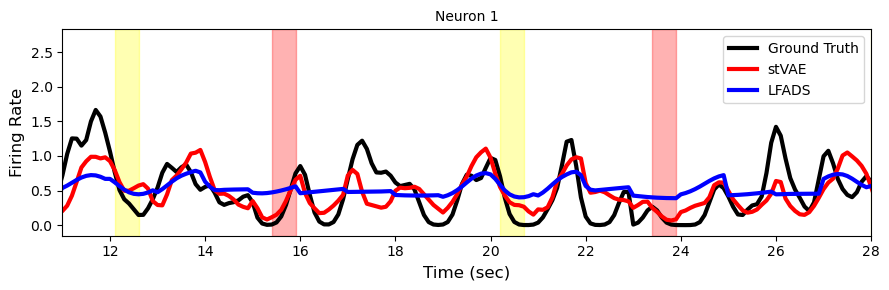

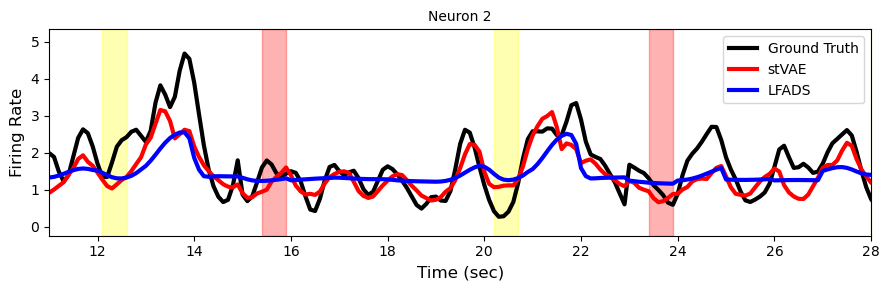

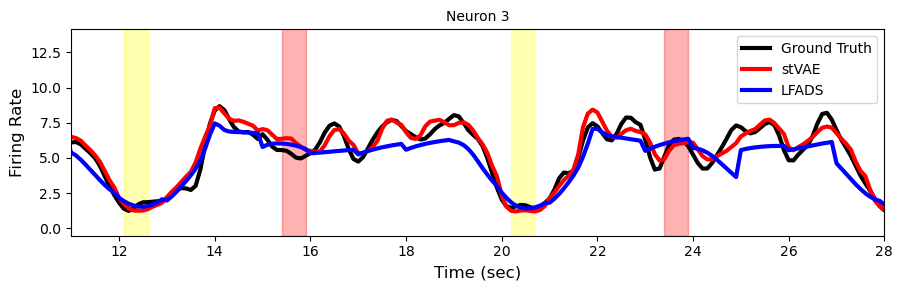

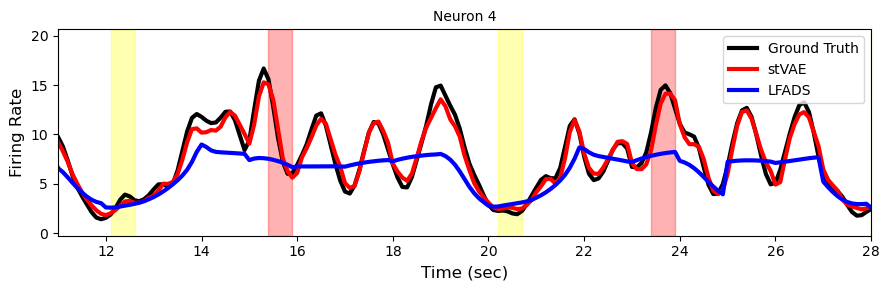

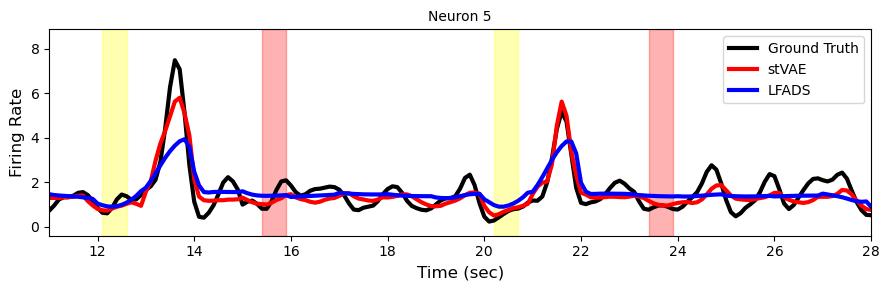

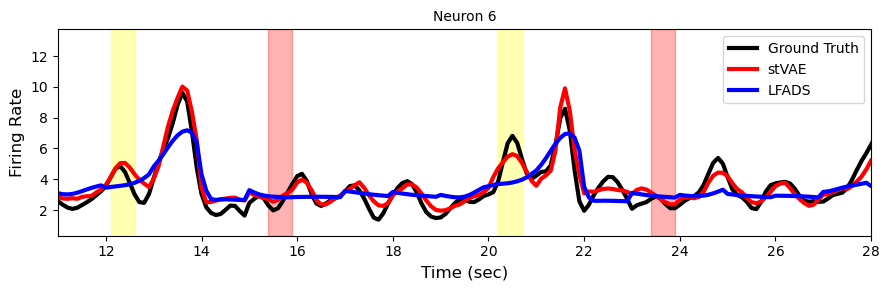

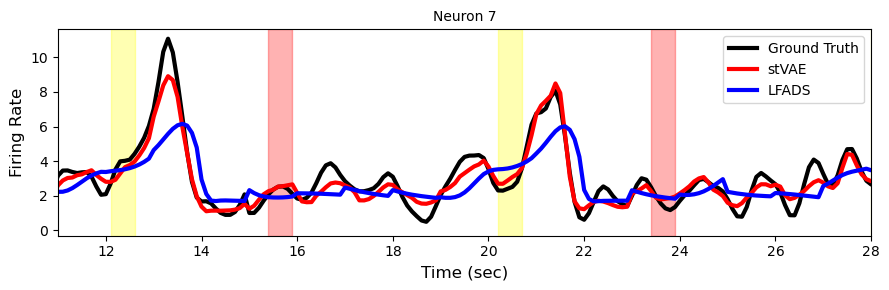

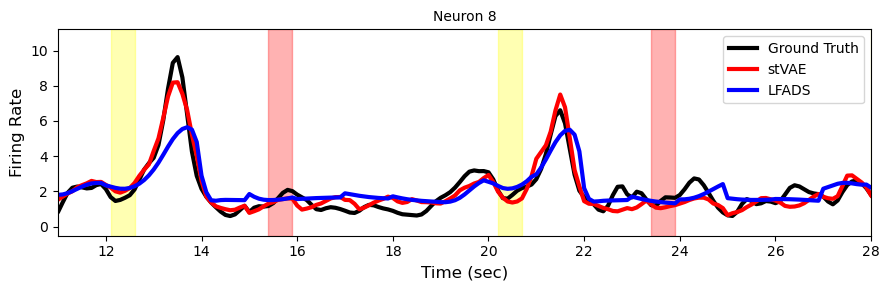

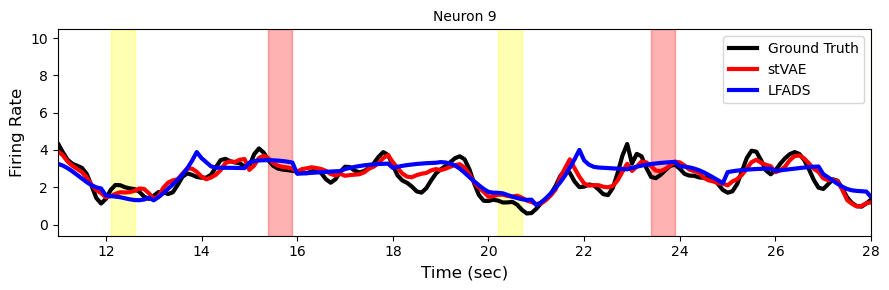

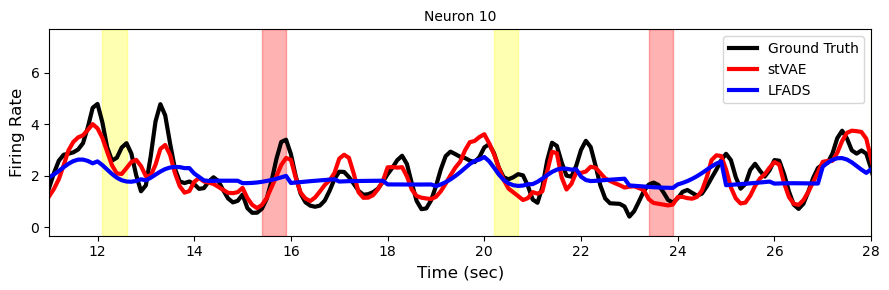

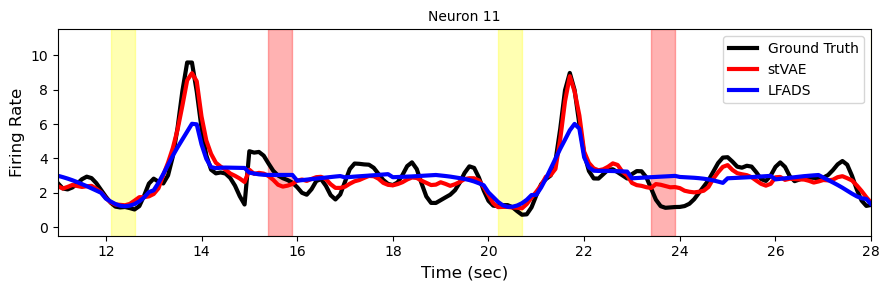

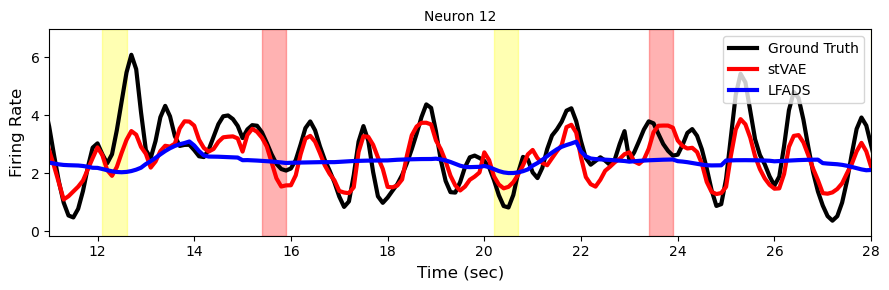

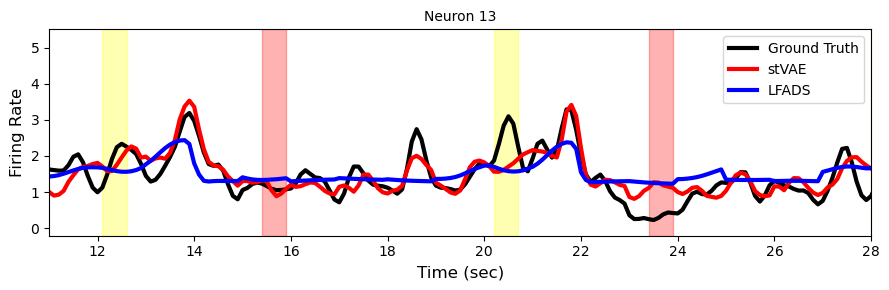

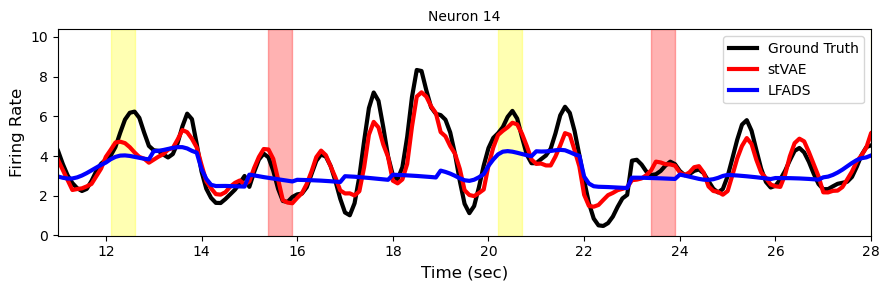

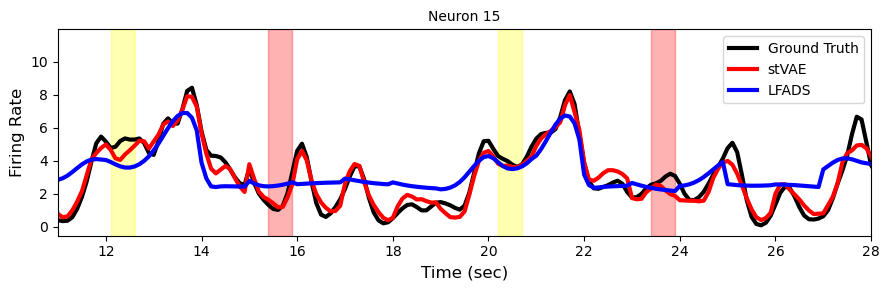

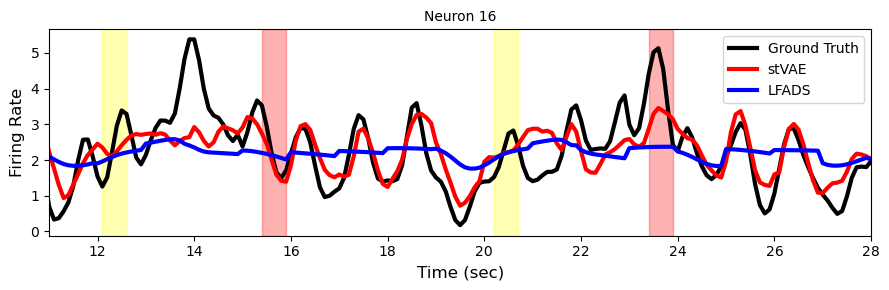

In [4]:
%matplotlib inline
# 计算 MSE 和 CC 的函数
def calculate_metrics(predictions, truth):
    mse = np.mean((predictions - truth) ** 2)
    cc = np.corrcoef(predictions.flatten(), truth.flatten())[0, 1]
    return mse, cc
colors = {'stVAE':'red','LFADS':'blue'}
truth = model_results['stVAE']['result_train']['truth']
events = model_results['stVAE']['result_train']['events']
actions = model_results['stVAE']['result_train']['actions']
## plot neuron
neuron_show = range(16)
time_steps = truth.shape[0]
time_limit = 3000  # Limit for clarity in plots

for neuron_index in neuron_show:
  
    # 创建图形
    plt.figure(figsize=(9, 3))
    plt.plot(np.arange(time_limit) * 0.1, truth[:time_limit, neuron_index], label='Ground Truth', color='black', linewidth=3)
    # 绘制真实数据（限制到 time_limit）
    for model_name in model_names:
        plt.plot(np.arange(time_limit) * 0.1, model_results[model_name]['result_train']['predictions'][:time_limit,neuron_index], label=model_name, color=colors[model_name], linewidth=3)
  
    # 绘制事件信息（限制到 time_limit）
    for t in range(time_limit):
        if events[t] == 0:
            plt.axvspan(t * 0.1, (t + 5) * 0.1, color='red', alpha=0.3)
        elif events[t] == 1:
            plt.axvspan(t * 0.1, (t + 5) * 0.1, color='yellow', alpha=0.3)
        elif events[t] == -1:
            plt.axvspan(t * 0.1, (t + 5) * 0.1, color='blue', alpha=0.3)
      
    title = (
        f"Neuron {neuron_index+1}"
    )
    plt.title(title, fontsize=10)
    
    # 设置坐标轴和图例
    plt.xlabel('Time (sec)', fontsize=12)
    plt.ylabel('Firing Rate', fontsize=12)
    plt.xlim(11, 28)  # 可根据需要调整时间范围
    plt.legend(loc='upper right', fontsize=10)
    
    # 调整布局并显示
    plt.tight_layout()
    plt.show()
    